<a href="https://colab.research.google.com/github/muhhanifra/CGAN-anime-google-colab/blob/master/dcgan_anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Anime Character Generation with DCGAN
In this notebook, we will demonstrate how we can use Deep Convolutional Generative Adversarial Networks (DCGAN) to generate 2D anime characters. The code is inspired by the tensorflow tutorial of DCGAN: https://www.tensorflow.org/tutorials/generative/dcgan. However, we will also discuss the mathematics of GAN in a little more detail and then see how it fits into the code.

In [ ]:
#as usual, let's start by importing all the libraries/modules
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython import display
import os
import time

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, BatchNormalization,ReLU, MaxPooling2D,Flatten,Dense
from tensorflow.keras.layers import Reshape, Conv2DTranspose,Dropout,LeakyReLU

## 1. Downloading and Exploring the dataset

The dataset consist of anime...

First, let's upload your kaggle.json in order to use kaggle API to download the dataset. 
More detail instruction can be seen [here](https://www.youtube.com/watch?v=tGw-ZACouik&t=169s)

In [ ]:
from google.colab import files
files.upload() #upload your own kaggle.json

The dataset that we will use for this notebook can be seen [here](https://). In order to get the dataset downloaded directly to your colab environment, you can do following command:

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change the permission
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d soumikrakshit/anime-faces

Also, it would be useful to use your google drive as we will put the saved models into google drive later on. It will probably take at most 2 GB, however if you dont have enough space on your drive, you can simply download the zipfile later on from colab directly.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #we will use put the model inside a google drive after the training

Mounted at /content/gdrive


In [ ]:
#unzip your dataset
import zipfile
zip_path = '/content/anime-faces.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_file:
  zip_file.extractall('dataset')

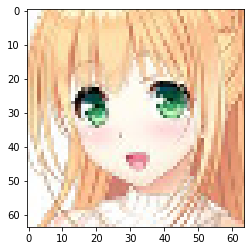

image size: (64, 64, 3)


In [ ]:
data_dir = '/content/dataset'
images_dir = os.path.join(data_dir, 'data')
image_filenames = os.listdir(images_dir)
#---see some images
image_path = os.path.join(images_dir,image_filenames[0])
img_sample = mpimg.imread(image_path)
plt.imshow(img_sample)
plt.show()

print('image size:',img_sample.shape)

In [ ]:
def normalize_img(img):
  return (img - 127.5)/127.5

In [ ]:
BATCH_SIZE = 64
it = ImageDataGenerator(preprocessing_function=normalize_img, horizontal_flip=False)
train_gen = it.flow_from_directory(data_dir, target_size=(64, 64), batch_size= BATCH_SIZE, class_mode= None, shuffle=True)

Found 43102 images belonging to 1 classes.


In [ ]:
#----------------creating discriminator-------------------
def create_discriminator():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), padding = 'same', input_shape = (64,64,3)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2D(32, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(64, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2D(64, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(128, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2D(128, (2,2), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(64,(1,1),padding = 'valid'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Flatten())
  model.add(Dense(1))

  return model

In [ ]:
disc = create_discriminator()
disc.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_105 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_106 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)      

In [ ]:
def create_generator():
  n = 8
  model = Sequential()
  
  model.add(Dense(n*n*256, use_bias = False,input_shape = (128, )))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  #model.add(Dropout(0.7))

  model.add(Reshape((n,n,256)))

  model.add(Conv2DTranspose(128, (3,3),strides = (2,2), padding = 'same',use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(128,(3,3),strides = (1,1),padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (3,3),strides = (2,2), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64,(3,3),strides = (1,1),padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(32, (3,3),strides = (2,2), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(32, (3,3),strides = (1,1), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(16, (3,3),strides = (1,1), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(8,(1,1),strides = (1,1),padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(3, (1, 1),strides = (1,1),padding = 'same',activation='tanh', use_bias = False))

  return model

In [ ]:
gen = create_generator()
gen.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16384)             2097152   
_________________________________________________________________
batch_normalization_112 (Bat (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_54 (Conv2DT (None, 16, 16, 128)       294912    
_________________________________________________________________
batch_normalization_113 (Bat (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 16, 16, 128)     

In [ ]:
#defining losses
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(true_output, fake_output):
  disc_term = cross_entropy(tf.ones_like(true_output, dtype=tf.float32)*0.9,true_output) #one sided label smoothing
  gen_term = cross_entropy(tf.zeros_like(fake_output),fake_output)
  loss = disc_term + gen_term
  return loss

def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

In [ ]:
#defining optimizer
disc_opt = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
gen_opt = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)

In [ ]:
num_epochs = 50
num_of_test = 64
seed = tf.random.normal([num_of_test,128])

In [ ]:
@tf.function
def train_step(x):
  noise = tf.random.normal([BATCH_SIZE,128])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_pred = gen(noise, training=True)

    disc_real = disc(x, training=True)
    disc_fake = disc(gen_pred, training = True)

    disc_loss = discriminator_loss(disc_real, disc_fake)
    gen_loss = generator_loss(disc_fake)

  gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
  disc_grads = disc_tape.gradient(disc_loss, disc.trainable_variables)

  gen_opt.apply_gradients(zip(gen_grads, gen.trainable_variables))
  disc_opt.apply_gradients(zip(disc_grads, disc.trainable_variables))

  return disc_loss, gen_loss

In [ ]:
def create_dir(path):
  try: 
      os.makedirs(path) 
      print("{} created".format(path)) 
  except: 
      print("skip, {} exist".format(path)) 

GAN_dir = '/content/GAN_1'
test_images_dir = os.path.join(GAN_dir, 'test_images')
checkpoints_dir = os.path.join(GAN_dir, 'model_checkpoints')

create_dir(GAN_dir)
create_dir(test_images_dir)
create_dir(checkpoints_dir)

skip, /content/GAN_1 exist
skip, /content/GAN_1/test_images exist
skip, /content/GAN_1/model_checkpoints exist


In [ ]:
def save_and_visualize_test(generator, discriminator,progress,seed, n_square = 8, dir = '/content/GAN'):
  #test generator on seed values
  test_fake_images = generator(seed, training = False)
  test_fake_images = np.uint8((test_fake_images*127.5) + 127.5)

  fig = plt.figure(figsize = (n_square,n_square))
  for i in range(n_square*n_square):
    plt.subplot(n_square,n_square,i+1)
    plt.imshow(test_fake_images[i, :,:,:])
    plt.axis('off')
  plt.show()
  #save models and sample images
  test_images_dir = os.path.join(dir, 'test_images')
  checkpoints_dir = os.path.join(dir, 'model_checkpoints')
  # save model
  epoch = progress['epoch']
  step = progress['step']
  generator.save(os.path.join(checkpoints_dir,'epoch-{}-step-{}-generator.hdf5'.format(f'{epoch:03}', f'{step:03}')))
  discriminator.save(os.path.join(checkpoints_dir,'epoch-{}-step-{}-discriminator.hdf5'.format(f'{epoch:03}', f'{step:03}')))
  # save images
  fig.savefig(os.path.join(test_images_dir,'epoch-{}-step-{}.jpg'.format(f'{epoch:03}', f'{step:03}')))

In [ ]:
m = train_gen.samples

epoch: 49 step: 600
disc_loss: 0.7834028 , gen_loss: 2.23637


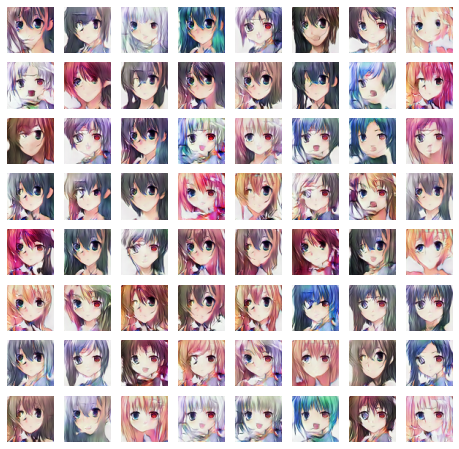

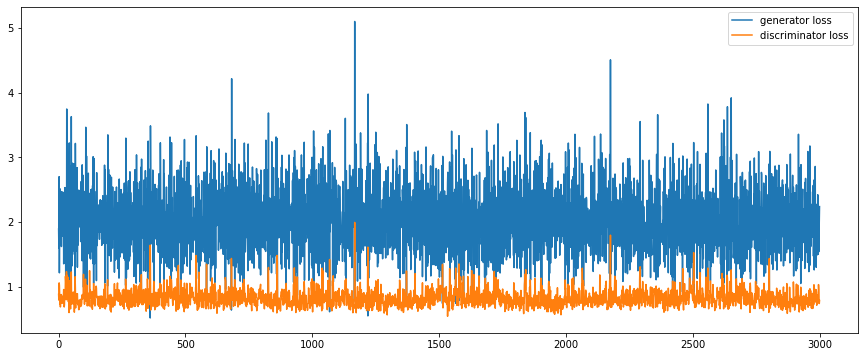

In [ ]:
num_steps = int(m/BATCH_SIZE)
disc_losses = []
gen_losses = []
for epoch in range(num_epochs):
  for step in range(num_steps):
    #minimax game with optimizer
    disc_loss, gen_loss = train_step(train_gen.next())
    #store models losses
    gen_losses.append(gen_loss.numpy())
    disc_losses.append(disc_loss.numpy())

    if step%200 == 0:
      #clear notebook output
      display.clear_output(wait=True)

      #print, visualize, and save progress
      progress = {'epoch':epoch, 'step':step}
      print('epoch:', epoch, 'step:', step)
      print('disc_loss:',disc_loss.numpy(), ', gen_loss:', gen_loss.numpy())
      save_and_visualize_test(gen,disc, progress, seed, dir = GAN_dir)

      #---plot discriminator and generator losss
      plt.figure(figsize=(15,6))
      plt.plot(gen_losses[-3000:])
      plt.plot(disc_losses[-3000:])
      plt.legend(['generator loss', 'discriminator loss'])
      plt.show()

In [ ]:
import shutil
shutil.make_archive("GAN_1", "zip", GAN_dir)
shutil.copy('/content/GAN_1.zip', '/content/gdrive/My Drive')

'/content/gdrive/My Drive/GAN_1.zip'

In [ ]:
gen_images_fn = os.listdir(test_images_dir)
gen_images_fn.sort()

In [ ]:
from PIL import Image

In [ ]:
gif_list = []
for filename in gen_images_fn:
  im_path = os.path.join(test_images_dir, filename)
  im_np = mpimg.imread(im_path)
  im = Image.fromarray(im_np)
  gif_list.append(im)

In [ ]:
gif_list[0].save('anime_dcgan.gif', save_all=True, append_images=gif_list[1:], optimize=True, duration=80, loop=0)